In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


In [2]:
# Define transformations (convert to tensor & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset info
print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


100%|██████████| 26.4M/26.4M [14:25<00:00, 30.5kB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 68.5kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [01:40<00:00, 43.9kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Training samples: 60000, Testing samples: 10000


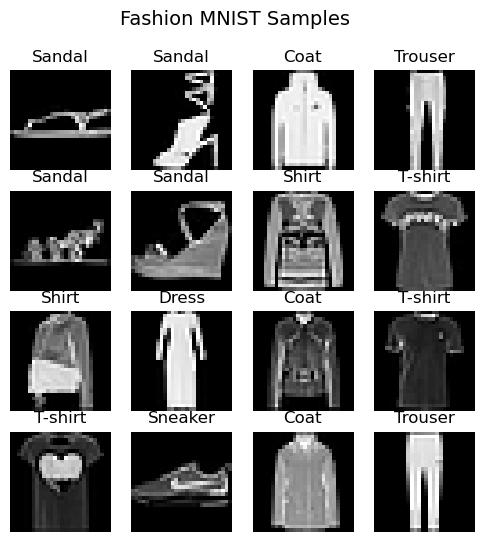

In [7]:
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define Transform (Convert to Tensor)
transform = transforms.Compose([transforms.ToTensor()])

# Load Fashion MNIST Dataset
dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Get a Batch of Images
images, labels = next(iter(dataloader))

# Class Labels for Fashion MNIST
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

# Plot Images in a Grid
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(class_names[labels[i].item()])
    ax.axis("off")

plt.suptitle("Fashion MNIST Samples", fontsize=14)
plt.show()


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Latent space
        self.fc_mu = nn.Linear(256, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Log Variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization Trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [4]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x.view(-1, 28*28), reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss


In [6]:
# Initialize model, optimizer
latent_dim = 20
vae = VAE(latent_dim=latent_dim).to("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 200
device = "cuda" if torch.cuda.is_available() else "cpu"

vae.train()
train_losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()

        recon_images, mu, logvar = vae(images)
        loss = vae_loss(recon_images, images, mu, logvar)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/200], Loss: 112.4648
Epoch [2/200], Loss: 75.3325
Epoch [3/200], Loss: 69.3400
Epoch [4/200], Loss: 66.6757
Epoch [5/200], Loss: 64.8368
Epoch [6/200], Loss: 63.7372
Epoch [7/200], Loss: 62.7573
Epoch [8/200], Loss: 62.0826
Epoch [9/200], Loss: 61.5363
Epoch [10/200], Loss: 61.0110
Epoch [11/200], Loss: 60.6343
Epoch [12/200], Loss: 60.2369
Epoch [13/200], Loss: 59.9359
Epoch [14/200], Loss: 59.6626
Epoch [15/200], Loss: 59.4359
Epoch [16/200], Loss: 59.2161
Epoch [17/200], Loss: 59.0207
Epoch [18/200], Loss: 58.7982
Epoch [19/200], Loss: 58.5954
Epoch [20/200], Loss: 58.4686
Epoch [21/200], Loss: 58.3565
Epoch [22/200], Loss: 58.2008
Epoch [23/200], Loss: 58.0357
Epoch [24/200], Loss: 57.9640
Epoch [25/200], Loss: 57.9650
Epoch [26/200], Loss: 57.7632
Epoch [27/200], Loss: 57.6705
Epoch [28/200], Loss: 57.5454
Epoch [29/200], Loss: 57.5196
Epoch [30/200], Loss: 57.4211
Epoch [31/200], Loss: 57.3149
Epoch [32/200], Loss: 57.2305
Epoch [33/200], Loss: 57.1632
Epoch [34/200], Lo

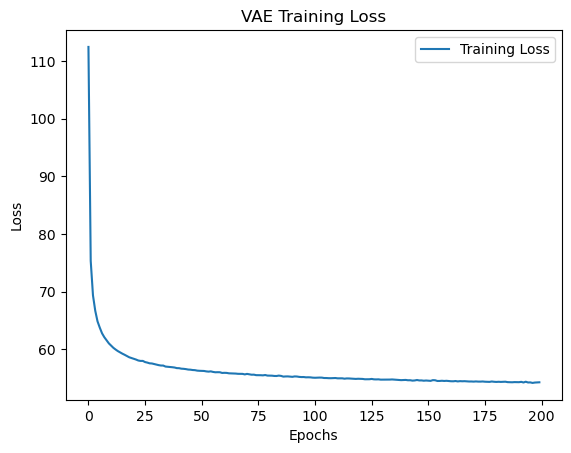

In [9]:
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.legend()
plt.show()


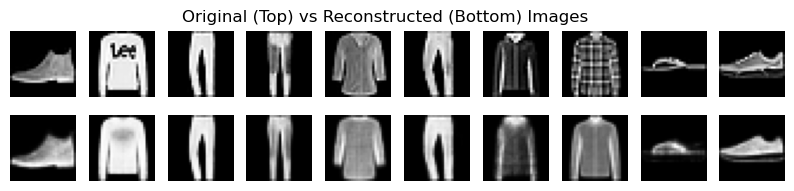

In [10]:
vae.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)
    recon_images, _, _ = vae(images)
    
    fig, axes = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        axes[0, i].imshow(images[i].cpu().numpy().squeeze(), cmap="gray")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(recon_images[i].cpu().numpy().reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    plt.suptitle("Original (Top) vs Reconstructed (Bottom) Images")
    plt.show()


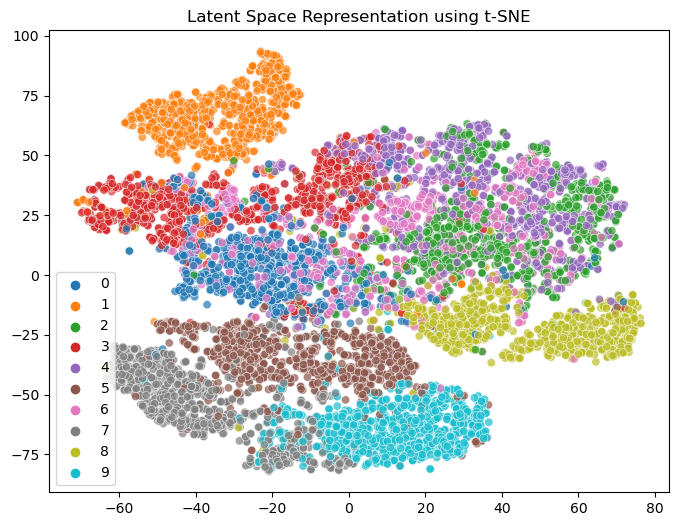

In [11]:
vae.eval()
all_mu = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        _, mu, _ = vae(images)
        all_mu.append(mu.cpu().numpy())
        all_labels.append(labels.numpy())

all_mu = np.concatenate(all_mu)
all_labels = np.concatenate(all_labels)

# Apply t-SNE for visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(all_mu)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=all_labels, palette="tab10", alpha=0.7)
plt.title("Latent Space Representation using t-SNE")
plt.show()


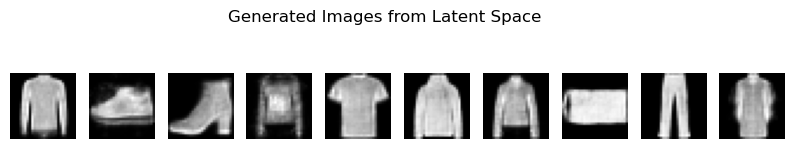

In [12]:
vae.eval()
num_samples = 10
latent_samples = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
    generated_images = vae.decode(latent_samples).cpu()

fig, axes = plt.subplots(1, num_samples, figsize=(10, 2))
for i in range(num_samples):
    axes[i].imshow(generated_images[i].numpy().reshape(28, 28), cmap="gray")
    axes[i].axis("off")

plt.suptitle("Generated Images from Latent Space")
plt.show()


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion MNIST Test Dataset
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("✅ Test dataset loaded successfully!")

import torch

# Define device (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")



✅ Test dataset loaded successfully!
✅ Using device: cpu


MODEL WASNT SAVED SO RUNNING AGAIN TO SAVE IT THIS TIME FOR FURTHER EVALUATION

In [8]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define Autoencoder (AE) Model
ae_model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)

# Train the Autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images
        optimizer.zero_grad()
        outputs = ae_model(images)
        loss = criterion(outputs, images)  # MSE Loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# Save the model for future use
torch.save(ae_model.state_dict(), "autoencoder.pth")
print("✅ Autoencoder training completed and model saved!")


Epoch [1/10], Loss: 0.6520
Epoch [2/10], Loss: 0.6071
Epoch [3/10], Loss: 0.6031
Epoch [4/10], Loss: 0.6006
Epoch [5/10], Loss: 0.5986
Epoch [6/10], Loss: 0.5971
Epoch [7/10], Loss: 0.5959
Epoch [8/10], Loss: 0.5950
Epoch [9/10], Loss: 0.5942
Epoch [10/10], Loss: 0.5936
✅ Autoencoder training completed and model saved!


In [9]:
# Load the trained autoencoder model
loaded_ae_model = Autoencoder().to(device)
loaded_ae_model.load_state_dict(torch.load("autoencoder.pth"))
loaded_ae_model.eval()  # Set to evaluation mode
print("✅ Autoencoder model loaded successfully!")


✅ Autoencoder model loaded successfully!


C:\Users\palak\AppData\Local\Temp\ipykernel_9844\1595940052.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_ae_model.load_state_dict(torch.load("autoencoder.pth")

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of test images
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
test_images, _ = next(iter(test_loader))

# Flatten images before passing them into the AE model
test_images_flatten = test_images.view(test_images.size(0), -1).to(device)

# Get the reconstructed images from the AE model
with torch.no_grad():
    ae_reconstructed = loaded_ae_model(test_images_flatten).cpu().view(-1, 28, 28)

# Plot the original and reconstructed images side-by-side
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    # Original Image (Top Row)
    axes[0, i].imshow(test_images[i].squeeze(), cmap="gray")
    axes[0, i].axis("off")

    # AE Reconstructed Image (Bottom Row)
    axes[1, i].imshow(ae_reconstructed[i], cmap="gray")
    axes[1, i].axis("off")

axes[0, 0].set_title("Original Images", fontsize=10)
axes[1, 0].set_title("AE Reconstructed Images", fontsize=10)
plt.show()
